# Welcome to the NoisePy SCEDC Tutorial!

Noisepy is a python software package to process ambient seismic noise cross correlations. 

**Publication about this software**:
Chengxin Jiang, Marine A. Denolle; NoisePy: A New High‐Performance Python Tool for Ambient‐Noise Seismology. Seismological Research Letters 2020; 91 (3): 1853–1866. doi: https://doi.org/10.1785/0220190364



This tutorial will walk you through the basic steps of using NoisePy to compute ambient noise cross correlation functions using single instance workflow.

The data is stored on AWS S3 as the SCEDC Data Set: https://scedc.caltech.edu/data/getstarted-pds.html



First, we install the noisepy-seis package

In [1]:
# Uncomment and run this line if the environment doesn't have noisepy already installed:
# ! pip install noisepy-seis 

__Warning__: NoisePy uses ```obspy``` as a core Python module to manipulate seismic data. Restart the runtime now for proper installation of ```obspy``` on Colab.

This tutorial should be ran after installing the noisepy package. 

## Import necessary modules

Then we import the basic modules

In [2]:
from noisepy.seis import cross_correlate, stack, plotting_modules, __version__       # noisepy core functions
from noisepy.seis.asdfstore import ASDFCCStore, ASDFStackStore          # Object to store ASDF data within noisepy
from noisepy.seis.scedc_s3store import SCEDCS3DataStore, channel_filter # Object to query SCEDC data from on S3
from noisepy.seis.datatypes import ConfigParameters                     # Main configuration object
from noisepy.seis.channelcatalog import XMLStationChannelCatalog        # Required stationXML handling object
import os
from datetime import datetime
from datetimerange import DateTimeRange
from noisepy.seis.noise_module import whiten, whiten_1D, whiten_1D

from matplotlib import pyplot as plt 
print(f"Using NoisePy version {__version__}")

path = "./scedc_data" 

os.makedirs(path, exist_ok=True)
cc_data_path = os.path.join(path, "CCF")
stack_data_path = os.path.join(path, "STACK")

Using NoisePy version 0.9.7.dev10


We will work with a single day worth of data on SCEDC. The continuous data is organized with a single day and channel per miniseed (https://scedc.caltech.edu/data/cloud.html). For this example, you can choose any year since 2002. We will just cross correlate a single day.

In [3]:
# SCEDC S3 bucket common URL characters for that day.
S3_DATA = "s3://scedc-pds/continuous_waveforms/"
# timeframe for analysis
start = datetime(2002, 1, 2)
end = datetime(2002, 1, 4)
range = DateTimeRange(start, end)
print(range)

2002-01-02T00:00:00 - 2002-01-04T00:00:00


The station information, including the instrumental response, is stored as stationXML in the following bucket

In [4]:
S3_STATION_XML = "s3://scedc-pds/FDSNstationXML/CI/"            # S3 storage of stationXML


## Ambient Noise Project Configuration

We store the metadata information about the ambient noise cross correlation workflow in a ConfigParameters() object. We first initialize it, then we tune the parameters for this cross correlation.

In [5]:
# Initialize ambient noise workflow configuration
config = ConfigParameters() # default config parameters which can be customized

Customize the job parameters below:

In [6]:

config.samp_freq= 20  # (int) Sampling rate in Hz of desired processing (it can be different than the data sampling rate)
config.cc_len= 3600.0  # (float) basic unit of data length for fft (sec)
    # criteria for data selection
config.ncomp = 3  # 1 or 3 component data (needed to decide whether do rotation)


config.acorr_only = False  # only perform auto-correlation or not
config.xcorr_only = True  # only perform cross-correlation or not

# config.inc_hours = 24 # if the data is first 

 # pre-processing parameters
config.step= 1800.0  # (float) overlapping between each cc_len (sec)
config.stationxml= False  # station.XML file used to remove instrument response for SAC/miniseed data
config.rm_resp= "inv"  # select 'no' to not remove response and use 'inv' if you use the stationXML,'spectrum',
config.freqmin = 0.05
config.freqmax = 10.0
config.max_over_std  = 10  # threshold to remove window of bad signals: set it to 10*9 if prefer not to remove them

# TEMPORAL and SPECTRAL NORMALISATION
config.freq_norm= "rma"  # choose between "rma" for a soft whitenning or "no" for no whitening. Pure whitening is not implemented correctly at this point.
config.smoothspect_N = 10  # moving window length to smooth spectrum amplitude (points)
    # here, choose smoothspect_N for the case of a strict whitening (e.g., phase_only)

config.time_norm = "no"  # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain,
    # TODO: change time_norm option from "no" to "None"
config.smooth_N= 10  # moving window length for time domain normalization if selected (points)

config.cc_method= "xcorr"  # 'xcorr' for pure cross correlation OR 'deconv' for deconvolution;
    # FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"

# OUTPUTS:
config.substack = True  # True = smaller stacks within the time chunk. False: it will stack over inc_hours
config.substack_len = config.cc_len  # how long to stack over (for monitoring purpose): need to be multiples of cc_len
    # if substack=True, substack_len=2*cc_len, then you pre-stack every 2 correlation windows.
    # for instance: substack=True, substack_len=cc_len means that you keep ALL of the correlations

config.maxlag= 200  # lags of cross-correlation to save (sec)
config.substack = True

In [7]:
# For this tutorial make sure the previous run is empty
os.system(f"rm -rf {cc_data_path}")


0

## Step 1: Cross-correlation



In [8]:

stations = "SBC,RIO,DEV".split(",") # filter to these stations
catalog = XMLStationChannelCatalog(S3_STATION_XML)
raw_store = SCEDCS3DataStore(S3_DATA, catalog, channel_filter(stations, "BH"), range) # Store for reading raw data from S3 bucket
cc_store = ASDFCCStore(cc_data_path) # Store for writing CC data

# print the configuration parameters. Some are chosen by default but we can modify them
print(config)

2024-07-05 10:31:27,110 INFO scedc_s3store._load_channels(): Loading 883 files from s3://scedc-pds/continuous_waveforms/2002/2002_002/
2024-07-05 10:31:27,119 INFO scedc_s3store._load_channels(): Init: 1 timespans and 9 channels
2024-07-05 10:31:29,126 INFO scedc_s3store._load_channels(): Loading 880 files from s3://scedc-pds/continuous_waveforms/2002/2002_003/
2024-07-05 10:31:29,135 INFO scedc_s3store._load_channels(): Init: 2 timespans and 18 channels


client_url_key='SCEDC' start_date=datetime.datetime(2019, 1, 1, 0, 0) end_date=datetime.datetime(2019, 1, 2, 0, 0) samp_freq=20 single_freq=True cc_len=3600.0 lamin=31.0 lamax=36.0 lomin=-122.0 lomax=-115.0 down_list=False net_list=['CI'] stations=['*'] channels=['BHE', 'BHN', 'BHZ'] step=1800.0 freqmin=0.05 freqmax=10.0 freq_norm='rma' time_norm='no' cc_method='xcorr' smooth_N=10 smoothspect_N=10 substack=True substack_len=3600.0 maxlag=200 inc_hours=24 max_over_std=10 ncomp=3 stationxml=False rm_resp='inv' rm_resp_out='VEL' respdir=None acorr_only=False xcorr_only=True stack_method=<StackMethod.LINEAR: 'linear'> keep_substack=False rotation=True correction=False correction_csv=None storage_options=defaultdict(<class 'dict'>, {})


In [9]:
# get one time series from the raw_store

span = raw_store.get_timespans()
channels = raw_store.get_channels(span[0])
d = raw_store.read_data(span[0], channels[2])


In [ ]:
data = d.data.astype("float32")

In [ ]:
#

    # delta = fft_para["dt"]
    # freqmin = fft_para["freqmin"]
    # freqmax = fft_para["freqmax"]
    # smooth_N = fft_para["smooth_N"]
    # freq_norm = fft_para["freq_norm"]

fft_para = {"dt": 1/d.sampling_rate, "freqmin": config.freqmin, "freqmax": config.freqmax, "smooth_N": config.smoothspect_N, "freq_norm": config.freq_norm}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.fftpack import next_fast_len
import time 

from noisepy.seis.noise_module import moving_ave, whiten, moving_ave_2D


def whiten_original(data, fft_para):
    """
    This function takes 1-dimensional timeseries array, transforms to frequency domain using fft,
    whitens the amplitude of the spectrum in frequency domain between *freqmin* and *freqmax*
    and returns the whitened fft.
    PARAMETERS:
    ----------------------
    data: numpy.ndarray contains the 1D time series to whiten
    fft_para: dict containing all fft_cc parameters such as
        dt: The sampling space of the `data`
        freqmin: The lower frequency bound
        freqmax: The upper frequency bound
        smooth_N: integer, it defines the half window length to smooth
        freq_norm: whitening method between 'one-bit' and 'RMA'
    RETURNS:
    ----------------------
    FFTRawSign: numpy.ndarray contains the FFT of the whitened input trace between the frequency bounds
    """

    # load parameters
    delta = fft_para["dt"]
    freqmin = fft_para["freqmin"]
    freqmax = fft_para["freqmax"]
    smooth_N = fft_para["smooth_N"]
    freq_norm = fft_para["freq_norm"]

    # Speed up FFT by padding to optimal size for FFTPACK
    if data.ndim == 1:
        axis = 0
    elif data.ndim == 2:
        axis = 1

    Nfft = int(next_fast_len(int(data.shape[axis])))
    print("Nfft",Nfft)
    Napod = 1000
    Nfft = int(Nfft)
    freqVec = scipy.fftpack.fftfreq(Nfft, d=delta)[: Nfft // 2]
    print(len(freqVec))
    J = np.where((freqVec >= freqmin) & (freqVec <= freqmax))[0]
    print(J[0])
    low = J[0] - Napod
    if low <= 0:
        low = 1

    left = J[0]
    right = J[-1]
    high = J[-1] + Napod
    if high > Nfft / 2:
        high = len(freqVec)-1 #int(Nfft // 2)
        print(len(freqVec)-1)
        print(int(Nfft//2))

    print("the 4 corners of the butterworth filter")
    print(low, left, right, high)
    print(len(freqVec))
    print(freqVec[low], freqVec[left], freqVec[right], freqVec[high])
    FFTRawSign = scipy.fftpack.fft(data, Nfft, axis=axis)
    print(FFTRawSign.shape)
    # Left tapering:
    if axis == 1:
        FFTRawSign[:, 0:low] *= 0
        FFTRawSign[:, low:left] = np.cos(np.linspace(np.pi / 2.0, np.pi, left - low)) ** 2 * np.exp(
            1j * np.angle(FFTRawSign[:, low:left])
        )
        # Pass band:
        if freq_norm == "phase_only":
            FFTRawSign[:, left:right] = np.exp(1j * np.angle(FFTRawSign[:, left:right]))
        elif freq_norm == "rma":
            for ii in range(data.shape[0]):
                tave = moving_ave(np.abs(FFTRawSign[ii, left:right]), smooth_N)
                FFTRawSign[ii, left:right] = FFTRawSign[ii, left:right] / tave
        # Right tapering:
        FFTRawSign[:, right:high] = np.cos(np.linspace(0.0, np.pi / 2.0, high - right)) ** 2 * np.exp(
            1j * np.angle(FFTRawSign[:, right:high])
        )
        FFTRawSign[:, high : Nfft // 2] *= 0

        # Hermitian symmetry (because the input is real)
        FFTRawSign[:, -(Nfft // 2) + 1 :] = np.flip(np.conj(FFTRawSign[:, 1 : (Nfft // 2)]), axis=axis)
    else:
        FFTRawSign[0:low] *= 0
        FFTRawSign[low:left] = np.cos(np.linspace(np.pi / 2.0, np.pi, left - low)) ** 2 * np.exp(
            1j * np.angle(FFTRawSign[low:left])
        )
        # Pass band:
        if freq_norm == "phase_only":
            FFTRawSign[left:right] = np.exp(1j * np.angle(FFTRawSign[left:right]))
        elif freq_norm == "rma":
            tave = moving_ave(np.abs(FFTRawSign[left:right]), smooth_N)
            FFTRawSign[left:right] = FFTRawSign[left:right] / tave
        # Right tapering:
        FFTRawSign[right:high] = np.cos(np.linspace(0.0, np.pi / 2.0, high - right)) ** 2 * np.exp(
            1j * np.angle(FFTRawSign[right:high])
        )
        FFTRawSign[high : Nfft // 2] *= 0

        # Hermitian symmetry (because the input is real)
        FFTRawSign[-(Nfft // 2) + 1 :] = FFTRawSign[1 : (Nfft // 2)].conjugate()[::-1]

    return FFTRawSign


# def whiten(data, fft_para, n_taper=1000):
    """
    This function takes a timeseries array, transforms to frequency domain using fft,
    whitens the amplitude of the spectrum in frequency domain between *freqmin* and *freqmax*
    and returns the whitened fft.
    PARAMETERS:
    ----------------------
    data: numpy.ndarray contains the 1D time series to whiten
    fft_para: dict containing all fft_cc parameters such as
        dt: The sampling space of the `data`
        freqmin: The lower frequency bound
        freqmax: The upper frequency bound
        smooth_N: integer, it defines the half window length to smooth
        freq_norm: whitening method between 'one-bit' and 'RMA'
    RETURNS:
    ----------------------
    FFTRawSign: numpy.ndarray contains the FFT of the whitened input trace between the frequency bounds
    """

    # Speed up FFT by padding to optimal size for FFTPACK
    if data.ndim == 1:
        FFTRawSign = whiten_1D(data, fft_para, n_taper)
        # ARR_OUT: Only for consistency with noisepy approach of holding the full
        # spectrum (not just 0 and positive freq. part)
        arr_out = np.zeros((FFTRawSign.shape[0] - 1) * 2 + 1, dtype=complex)
        arr_out[0 : FFTRawSign.shape[0]] = FFTRawSign
        arr_out[FFTRawSign.shape[0] :] = FFTRawSign[1:].conjugate()[::-1]

    elif data.ndim == 2:
        FFTRawSign = whiten_2D(data, fft_para, n_taper)
        arr_out = np.zeros((FFTRawSign.shape[0], (FFTRawSign.shape[1] - 1) * 2 + 1), dtype=complex)
        arr_out[:, FFTRawSign.shape[1] :] = FFTRawSign[:, 1:].conjugate()[::-1]
    return FFTRawSign



# def whiten_1D(timeseries, fft_para, n_taper):
#     """
#     This function takes a 1-dimensional timeseries array, transforms to frequency domain using fft,
#     whitens the amplitude of the spectrum in frequency domain between *freqmin* and *freqmax*
#     and returns the whitened fft.
#     PARAMETERS:
#     ----------------------
#     data: numpy.ndarray contains the 1D time series to whiten
#     fft_para: dict containing all fft_cc parameters such as
#         dt: The sampling space of the `data`
#         freqmin: The lower frequency bound
#         freqmax: The upper frequency bound
#         smooth_N: integer, it defines the half window length to smooth
#         n_taper, optional: integer, define the width of the taper in samples
#     RETURNS:
#     ----------------------
#     FFTRawSign: numpy.ndarray contains the FFT of the whitened input trace between the frequency bounds
#     """
#     # load parameters
#     delta = fft_para["dt"]
#     freqmin = fft_para["freqmin"]
#     freqmax = fft_para["freqmax"]
#     smooth_N = fft_para["smoothspect_N"]
#     print("whitening in 1D")

#     nfft = next_fast_len(len(timeseries))
#     spec = np.fft.fft(timeseries, nfft)
#     freq = np.fft.fftfreq(nfft, d=delta)

#     ix0 = np.argmin(np.abs(freq - freqmin))
#     ix1 = np.argmin(np.abs(freq - freqmax))

#     if ix1 + n_taper > nfft:
#         ix11 = nfft
#     else:
#         ix11 = ix1 + n_taper

#     if ix0 - n_taper < 0:
#         ix00 = 0
#     else:
#         ix00 = ix0 - n_taper

#     print(ix00, ix0, ix1, ix11)
#     spec_out = spec.copy()
#     spec_out[0:ix00] = 0.0 + 0.0j
#     spec_out[ix11:] = 0.0 + 0.0j
#     del spec

#     if smooth_N <= 1:
#         spec_out[ix00:ix11] = np.exp(1.0j * np.angle(spec_out[ix00:ix11]))
#     else:
#         spec_out[ix00:ix11] /= moving_ave(np.abs(spec_out[ix00:ix11]), smooth_N)

#     x = np.linspace(np.pi / 2.0, np.pi, ix0 - ix00)
#     spec_out[ix00:ix0] *= np.cos(x) ** 2

#     x = np.linspace(0.0, np.pi / 2.0, ix11 - ix1)
#     spec_out[ix1:ix11] *= np.cos(x) ** 2

#     return spec_out


# def whiten_2D(timeseries, fft_para, n_taper):
    """
    This function takes a 2-dimensional timeseries array, transforms to frequency domain using fft,
    whitens the amplitude of the spectrum in frequency domain between *freqmin* and *freqmax*
    and returns the whitened fft.
    PARAMETERS:
    ----------------------
    data: numpy.ndarray contains the 1D time series to whiten
    fft_para: dict containing all fft_cc parameters such as
        dt: The sampling space of the `data`
        freqmin: The lower frequency bound
        freqmax: The upper frequency bound
        smooth_N: integer, it defines the half window length to smooth
        n_taper, optional: integer, define the width of the taper in samples
    RETURNS:
    ----------------------
    FFTRawSign: numpy.ndarray contains the FFT of the whitened input trace between the frequency bounds
    """
    # load parameters
    delta = fft_para["dt"]
    freqmin = fft_para["freqmin"]
    freqmax = fft_para["freqmax"]
    smooth_N = fft_para["smooth_N"]

    nfft = next_fast_len(timeseries.shape[1])
    spec = np.fft.fftn(timeseries, s=[nfft])
    freq = np.fft.fftfreq(nfft, d=delta)

    ix0 = np.argmin(np.abs(freq - freqmin))
    ix1 = np.argmin(np.abs(freq - freqmax))

    if ix1 + n_taper > nfft:
        ix11 = nfft
    else:
        ix11 = ix1 + n_taper

    if ix0 - n_taper < 0:
        ix00 = 0
    else:
        ix00 = ix0 - n_taper

    spec_out = spec.copy()  # may be inconvenient due to higher memory usage
    spec_out[:, 0:ix00] = 0.0 + 0.0j
    spec_out[:, ix11:] = 0.0 + 0.0j

    if smooth_N <= 1:
        spec_out[:, ix00:ix11] = np.exp(1.0j * np.angle(spec_out[:, ix00:ix11]))
    else:
        spec_out[:, ix00:ix11] /= moving_ave_2D(np.abs(spec_out[:, ix00:ix11]), smooth_N)

    x = np.linspace(np.pi / 2.0, np.pi, ix0 - ix00)
    spec_out[:, ix00:ix0] *= np.cos(x) ** 2

    x = np.linspace(0.0, np.pi / 2.0, ix11 - ix1)
    spec_out[:, ix1:ix11] *= np.cos(x) ** 2

    return spec_out

# test case:
# the non-smoothed version of whitening needs to return the same as the original version.
# it is not expected that the smoothed version returns the same, so currently no test for that
# (would be good to add one based on some expected outcome)

def whiten1d():
    # 1 D case
    data = np.random.random(1000)
    t1=time.time()
    white_original = whiten_original(data, fft_para)
    t2=time.time()
    white_new = whiten(data, fft_para)
    t3=time.time()
    print("1D FFT took in scipy %f and in numpy %f"%(t2-t1,t3-t2))

    # A strict test does not work because the
    assert np.sqrt(np.sum((white_original[0:500] - white_new[0:500]) ** 2) / 500.0) < 0.01 * white_new.max()
    print("1D ok")
    return white_original, white_new


def whiten2d():
    # 2 D case
    data = np.random.random((5, 1000))
    t1=time.time()
    white_original = whiten_original(data, fft_para)
    t2=time.time()
    white_new = whiten(data, fft_para)
    t3=time.time()
    print("2D FFT took in scipy %f and in numpy %f"%(t2-t1,t3-t2))

    for i in range(5):
        assert (
            np.sqrt(np.sum((white_original[i, 0:500] - white_new[i, 0:500]) ** 2) / 500.0)
            < 0.01 * white_new[i, :].max()
        )
    print("2D ok")
    return white_original, white_new


def plot_1d(white_original, white_new):
    plt.plot(white_original[0:501].real)
    plt.plot(white_new.real)
    plt.show()
    plt.plot(white_original[100:500].real - white_new[100:500].real)
    plt.show()
    plt.plot(white_original[100:500].imag - white_new[100:500].imag)
    plt.show()


def plot_2d(white_original, white_new):
    for i in range(5):
        plt.plot(white_original[i, :].real)
        plt.plot(white_new[i, :].real)
    plt.show()
    for i in range(5):
        plt.plot(white_original[i, 100:500].real - white_new[i, 100:500].real)
    plt.show()
    for i in range(5):
        plt.plot(white_original[i, 100:500].imag - white_new[i, 100:500].imag)
    plt.show()



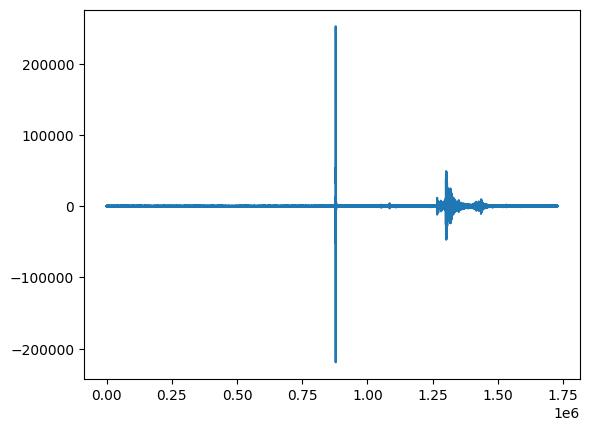

In [ ]:
plt.plot(data)

In [ ]:
fft_para['smoothspect_N']=100

In [ ]:

white_original = whiten_original(data, fft_para)
white_new = whiten(data, fft_para)

Nfft 1728000
864000
4321
863999
864000
the 4 corners of the butterworth filter
4221 4321 863999 863999
864000
0.048854166666666664 0.05001157407407407 9.999988425925926 9.999988425925926
(1728000,)
whitening in 1D
3320 4320 863999 864999


In [ ]:
# create the fft vectors
from scipy.fftpack import next_fast_len

Nfft = int(next_fast_len(int(data.shape[0])))
delta = 1 / d.sampling_rate
freqVec = scipy.fftpack.fftfreq(Nfft, d=delta)[: Nfft // 2]
freq_numpy= np.fft.fftfreq(Nfft, 1/d.sampling_rate)
Napod = 100
    

In [ ]:
fft_para["smooth_N"]=1000
fft_para["freq_norm"]="rma"

white_original = whiten_original(data, fft_para)
white_new = whiten(data, fft_para)
# fft_para = {"dt": 1/d.sampling_rate, "freqmin": config.freqmin, "freqmax": config.freqmax, "smooth_N": config.smoothspect_N, "freq_norm": config.freq_norm}

Nfft 1728000
864000
4321
863999
864000
the 4 corners of the butterworth filter
4221 4321 863999 863999
864000
0.048854166666666664 0.05001157407407407 9.999988425925926 9.999988425925926
(1728000,)
whitening in 1D
3320 4320 863999 864999


[0.00000000e+00 1.15740741e-05 2.31481481e-05 3.47222222e-05
 4.62962963e-05 5.78703704e-05 6.94444444e-05 8.10185185e-05
 9.25925926e-05 1.04166667e-04 1.15740741e-04 1.27314815e-04
 1.38888889e-04 1.50462963e-04 1.62037037e-04 1.73611111e-04
 1.85185185e-04 1.96759259e-04 2.08333333e-04 2.19907407e-04] [ 0.+0.j  0.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-0.j  0.+0.j  0.-0.j  0.+0.j  0.-0.j
  0.+0.j -0.+0.j]


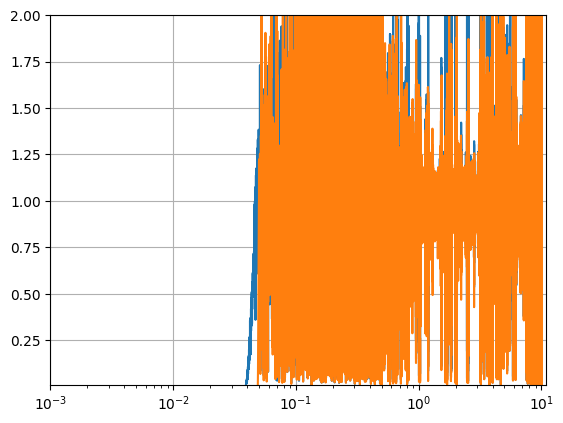

In [ ]:

plt.plot(freq_numpy[:len(freq_numpy)//2],np.abs(white_new[:len(freq_numpy)//2]))
plt.plot(freqVec,np.abs(white_original[:len(freqVec)]))
plt.xscale("log");plt.grid();#plt.yscale("log") ;
plt.xlim([0.001,11]);plt.ylim([0.01,2])
print(freqVec[0:20],white_original[0:20])

Redo the whitening itself

In [ ]:
data.shape,freq.shape

((1728000,), (1728000,))

In [ ]:
from noisepy.seis.noise_module import noise_processing
fft_para['dt']=1/d.sampling_rate
fft_para["time_norm"] = "no"
fft_para["freq_norm"] = "rma"
fft_para["smoothfreq_N"] = 100
fft_para["smooth_N"] = 1
white=noise_processing(fft_para,data)

In [ ]:
white.shape

(1728000,)

In [ ]:
freq[nfft//2-1],freq[nfft//2],freq[nfft//2+1]

(9.999988425925926, -10.0, -9.999988425925926)

In [ ]:
white_original.shape

(1728000,)

In [ ]:
config.freqmax,config.freqmin

(10.0, 0.05)

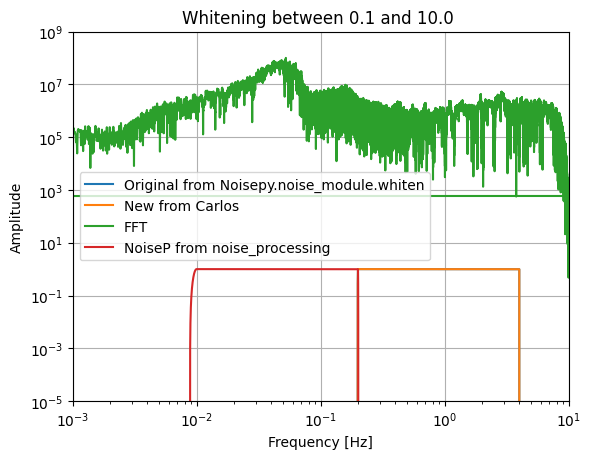

In [ ]:
plt.plot(freq,np.abs(white_original))
plt.plot(freq,np.abs(white_new))
plt.plot(freq,np.abs(spec))
plt.plot(freq,np.abs(white))
plt.xlim([0.001,10]);plt.grid()
plt.ylim([1e-5,1e9])
plt.xscale("log");plt.yscale("log");
plt.legend(["Original from Noisepy.noise_module.whiten","New from Carlos","FFT","NoiseP from noise_processing"])
plt.xlabel("Frequency [Hz]");plt.ylabel("Amplitude");
plt.title("Whitening between %.1f and %1.1f "%(config.freqmin,config.freqmax));


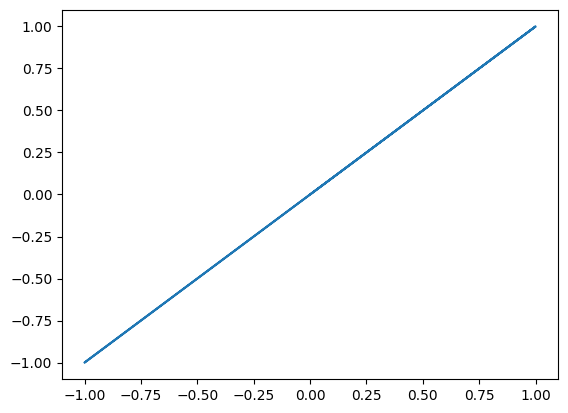

In [ ]:
plt.plot(white_original[100:500].real,white_new[100:500].real)

In [ ]:

# white_original, white_new = whiten2d()
# plot_2d(white_original, white_new)


In [ ]:
def noise_processing(fft_para: ConfigParameters, dataS):
    """
    this function performs time domain and frequency domain normalization if needed. in real case, we prefer use include
    the normalization in the cross-correaltion steps by selecting coherency or decon
    (Prieto et al, 2008, 2009; Denolle et al, 2013)
    PARMAETERS:
    ------------------------
    fft_para: ConfigParameters class containing all useful variables used for fft and cc
    dataS: 2D matrix of all segmented noise data
    # OUTPUT VARIABLES:
    source_white: 2D matrix of data spectra
    """
    # ------to normalize in time or not------
    if fft_para.time_norm != TimeNorm.NO:
        if fft_para.time_norm == TimeNorm.ONE_BIT:  # sign normalization
            white = np.sign(dataS)
        elif fft_para.time_norm == TimeNorm.RMA:  # running mean: normalization over smoothed absolute average
            white = np.zeros(shape=dataS.shape, dtype=dataS.dtype)
            for kkk in range(dataS.shape[0]):
                white[kkk, :] = dataS[kkk, :] / moving_ave(np.abs(dataS[kkk, :]), fft_para.smooth_N)

    else:  # don't normalize
        white = dataS

    # -----to whiten or not------
    if fft_para.freq_norm != FreqNorm.NO:
        source_white = whiten(white, fft_para)  # whiten and return FFT
    else:
        Nfft = int(next_fast_len(int(dataS.shape[1])))
        source_white = scipy.fftpack.fft(white, Nfft, axis=1)  # return FFT

    return source_white

Plot a single set of the cross correlation

In [ ]:
timespans = cc_store.get_timespans()
plotting_modules.plot_substack_cc(cc_store, timespans[0], 0.1, 1, 200, False)

## Step 3: Stack the cross correlation

Provide a path to where the data is.

In [ ]:
# open a new cc store in read-only mode since we will be doing parallel access for stacking
cc_store = ASDFCCStore(cc_data_path, mode="r")
stack_store = ASDFStackStore(stack_data_path)
stack(cc_store, stack_store, config)

Plot the stacks

In [ ]:
print(os.listdir(cc_data_path))
print(os.listdir(stack_data_path))

In [ ]:
plotting_modules.plot_all_moveout(stack_store, 'Allstack_linear', 0.1, 0.2, 'ZZ', 1)